In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


In [3]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

In [4]:
classification_id = '20190529_2'
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_' + classification_id
data_snippets_dir = 'ver4_machine_learning_flight_classification_tsne_cfg3_' + classification_id

subset_classification_slug = 'ver4_ml_tsne_cfg3_' + classification_id

os.makedirs(data_snippets_dir, exist_ok=True)

# Selecting the flight data

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls,
    readonly=False
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

## Columns

In [6]:
rfecv_selector_on_extra_trees__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_extra_trees__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20190529_2/rfecv_selector_on_extra_trees__column_names.txt


In [7]:
rfecv_selector_on_extra_trees__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_extra_trees__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20190529_2/rfecv_selector_on_extra_trees__column_names__special.txt


In [8]:
# This should be empty for now
rfecv_selector_on_extra_trees__column_names__special

[]

In [9]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
        ('gps_datetime_min')
    ] + rfecv_selector_on_extra_trees__column_names
)

classification_flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=rfecv_selector_on_extra_trees__column_names
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_gps_datetime
	- min

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- sizes_min
	- sizes_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- sizes_max
	- max_size_clu_width
	- max_size_clu_heig

WARNING: not selecting NULL trg lines

## Event classes

In [10]:
EVENT_CLASSES = {
    'dot': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21,
    #
    'unclassified': -1
}

In [11]:
len(EVENT_CLASSES)

23

In [12]:
INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}

## Constructing the query

In [13]:
classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'

current_columns_for_analysis_dict = flight_columns_for_analysis_dict

flight_select_clause_str, flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
    **current_columns_for_analysis_dict,
    classification_table_name: ['class_number']
})

flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(flight_tables_list)

flight_source_data_type_num = 1

flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
'''

for table, cols_list in classification_flight_columns_for_analysis_dict.items():
    for col in cols_list:
        flight_where_clauses_str += ' AND {}.{} IS NOT NULL\n'.format(table, col)

flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=flight_source_data_type_num,
    select_additional=flight_select_clause_str, 
    join_additional=flight_clauses_str,
    where_additional=flight_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

In [14]:
print(flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean_gz AS trg_box_per_gtu_mean_gz, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_per_gtu_sum, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.mean AS t

In [15]:
flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [16]:
manual_classification_class_number_column = 'manual_classification_class_number'

In [17]:
flight_df.loc[flight_df[manual_classification_class_number_column].isnull(), 
              manual_classification_class_number_column] = -1

In [18]:
len(flight_df)

146116

In [19]:
manual_classification_class_name_column = 'manual_classification_class_name'

In [20]:
flight_df[manual_classification_class_name_column] = 'unclassified'
for class_name, class_number in EVENT_CLASSES.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_name_column] = class_name

In [21]:
flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_x_y_hough_peak_thr2_line_clusters_count,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width,manual_classification_class_number,manual_classification_class_name
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,8,8,1,4.74049,4.60184,5.41446,15,15,-1.0,unclassified
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,6,25,4,2.31214,1.70155,2.29509,19,19,-1.0,unclassified
2,68,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,177,1,49,9,1.0,...,48,48,1,3.52568,3.15889,1.96062,25,25,-1.0,unclassified
3,72,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,287,2,31,9,1.0,...,84,84,4,4.01495,2.76942,3.05407,22,22,-1.0,unclassified
4,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,100,100,4,2.44340,5.69936,5.69849,45,45,-1.0,unclassified


In [22]:
flight_df[rfecv_selector_on_extra_trees__column_names].head()

,num_gtu,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_max,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_sizes_min,...,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_height,alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_x_y_hough_peak_thr2_line_clusters_count,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width
0,11,7.0,9.0,0.818182,1.0,3.0,0.272727,3.0,0.272727,1,...,3,8,8,8,1,4.74049,4.60184,5.41446,15,15
1,11,7.0,15.0,1.363640,2.0,4.0,0.363636,3.0,0.272727,7,...,2,25,6,25,4,2.31214,1.70155,2.29509,19,19
2,9,1.0,1.0,0.111111,1.0,1.0,0.111111,1.0,0.111111,1,...,10,48,48,48,1,3.52568,3.15889,1.96062,25,25
3,9,1.0,1.0,0.111111,1.0,1.0,0.111111,1.0,0.111111,1,...,42,84,84,84,4,4.01495,2.76942,3.05407,22,22
4,22,7.0,22.0,1.000000,2.0,10.0,0.454545,10.0,0.454545,16,...,54,100,100,100,4,2.44340,5.69936,5.69849,45,45


In [23]:
np.count_nonzero(flight_df['event_id'].isnull())

0

In [24]:
flight_df['had_nan_fields'] = flight_df[rfecv_selector_on_extra_trees__column_names].isnull().any(axis=1)

In [25]:
np.count_nonzero(flight_df['had_nan_fields'])

0

In [26]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [27]:
len(flight_df_nonan)

146116

In [28]:
cur = event_v3_storage_provider_flight.connection.cursor()

In [31]:
cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 60
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 31 <= gtu_in_packet AND gtu_in_packet <= 67
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num}
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 60
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 31 AND 67
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_events = cur.fetchone()[0]

In [32]:
print('number of all         packets', num_all_packets)
print('number of gtu [36,60] packets', num_gtu_36_60_packets)
print('number of gtu [31,67] packets', num_gtu_31_67_packets)
print('-'*50)
print('number of all         events ', num_all_events)
print('number of gtu [36,60] events ', num_gtu_36_60_events)
print('number of gtu [31,67] events ', num_gtu_31_67_events)
print('-'*50)
print('sel. fraction of all         events {:.3f}'.format(len(flight_df_nonan) / num_all_events))
print('sel. fraction of gtu [36,60] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_36_60_events))
print('sel. fraction of gtu [31,67] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_31_67_events))

number of all         packets 145648
number of gtu [36,60] packets 137363
number of gtu [31,67] packets 139935
--------------------------------------------------
number of all         events  243622
number of gtu [36,60] events  156135
number of gtu [31,67] events  167354
--------------------------------------------------
sel. fraction of all         events 0.600
sel. fraction of gtu [36,60] events 0.936
sel. fraction of gtu [31,67] events 0.873


In [31]:
# TODO
# SELECT COUNT(*) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT( DISTINCT (source_file_acquisition, packet_id)) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT(*) FROM (SELECT DISTINCT source_file_acquisition, packet_id  FROM spb_processing_v4_flatmap.event WHERE source_data_type_num=1) AS s;

# Applying models

This model does not use scaled data

In [32]:
# standard_scaler_on_train_rfecv_columns_pathname = \
#      os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
# standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [33]:
# flight__rfecv_columns_scaled_X = \
#     standard_scaler_on_train_rfecv_columns.transform(
#         flight_df[rfecv_selector_on_extra_trees__column_names].values)
# if np.count_nonzero(flight_df['had_nan_fields']) > 0:
#     flight_nonan__rfecv_columns_scaled_X = \
#         standard_scaler_on_train_rfecv_columns.transform(
#             flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values)
# else:
#     flight_nonan__rfecv_columns_scaled_X = flight__rfecv_columns_scaled_X

## Extra trees classifier

In [35]:
flight_rfecv_columns__X  = flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values

In [36]:
extra_trees_cls_on_train_rfecv__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'extra_trees_cls_on_train_rfecv.pkl')
extra_trees_cls_on_train_rfecv_est = joblib.load(extra_trees_cls_on_train_rfecv__model_plk_pathname)

In [37]:
cls_column_base = 'extra_trees_cls_on_train_rfecv_est'
cls_column = cls_column_base + '_dropna'
cls_proba_column = 'extra_trees_cls_on_train_rfecv_est_dropna_proba'

In [38]:
# this might not be correct (but for this particular selection it should be fine becaus flight_df_nonan == flight_df )
flight_df[cls_column_base] = \
    extra_trees_cls_on_train_rfecv_est.predict(flight_rfecv_columns__X)

flight_df[cls_column] = \
    ((flight_df[cls_column_base]==1) & ~flight_df['had_nan_fields']).astype('int8')

In [39]:
flight_df[cls_proba_column] = np.nan
flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), cls_proba_column] = \
    extra_trees_cls_on_train_rfecv_est.predict_proba(flight_rfecv_columns__X)[:,1]

### Updating `flight_df_nonan` with classification predictions
(not in the report)

In [40]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

### Statistics of selected events

In [41]:
# flight_df_nonan.group_by(['')

AttributeError: 'DataFrame' object has no attribute 'group_by'

#### Number of events classified "air shower"

In [42]:
np.count_nonzero(flight_df_nonan[cls_column])

14134

#### Events classified "air shower" - fraction of classified events

In [41]:
np.count_nonzero(flight_df_nonan[cls_column])/len(flight_df_nonan)

0.09673136412165677

#### Events classified "air shower" - describe

In [42]:
flight_df_nonan[[cls_column, cls_proba_column]].describe()

,extra_trees_cls_on_train_rfecv_est_dropna,extra_trees_cls_on_train_rfecv_est_dropna_proba
count,146116.000000,146116.000000
mean,0.096731,0.138675
std,0.295593,0.208870
min,0.000000,0.000000
25%,0.000000,0.003079
50%,0.000000,0.024412
75%,0.000000,0.215648
max,1.000000,0.991726


#### Events classified "air shower" - number of events by probability

In [43]:
for proba in np.arange(0.5, 1.0, 0.1):
    print('p > {:.2f}: {}'.format(proba, np.count_nonzero(flight_df[cls_proba_column] > proba)))

p > 0.50: 14134
p > 0.60: 9400
p > 0.70: 4297
p > 0.80: 657
p > 0.90: 70


#### Events classified "air shower" - fraction of all events

In [44]:
np.count_nonzero(flight_df_nonan[cls_column])/num_all_events

0.05801610691973631

#### Events classified "air shower" - fraction of all events in gtu [36, 60]

In [45]:
np.count_nonzero(flight_df_nonan.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column])/num_gtu_36_60_events

0.06590647623769298

#### Packets classified "air shower" - fraction of all packets

In [46]:
num_cls_1_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1].groupby(
        ['source_file_acquisition', 'packet_id']).count()['event_id'])

In [47]:
num_cls_1_packets/num_all_packets

0.08356448423596617

#### Events classified "air shower" - fraction of all packets triggered in gtu [36, 60]

In [48]:
num_cls_1_gtu_36_60_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1] \
            .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
            .groupby(['source_file_acquisition', 'packet_id']) \
            .count()['event_id'])

In [49]:
num_cls_1_gtu_36_60_packets/num_gtu_36_60_events

0.060319457951172384

### Distribution of classified events by date

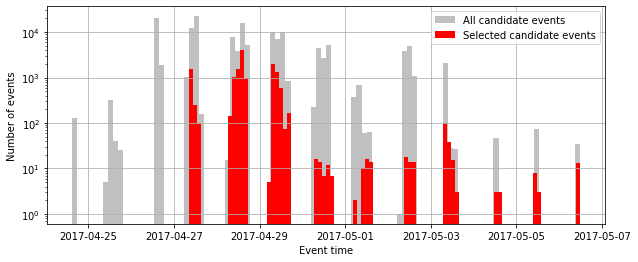

In [44]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='All candidate events')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Selected candidate events')
ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'Distribution of classified events by date - log.svg'))
plt.show()

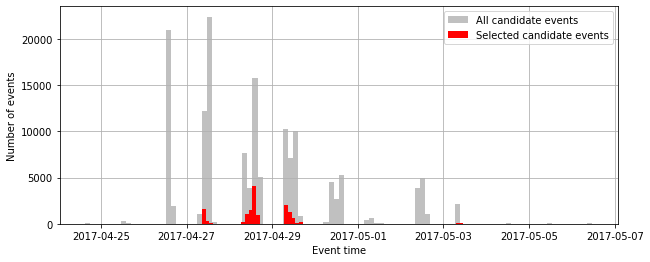

In [47]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='All candidate events')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Selected candidate events')
# ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'Distribution of classified events by date - linear.svg'))
plt.show()

In [52]:
# TODO 
# - trigger rate S
# - trigger rate by manual classification

### Trigger rate

#### All flight HW events

In [61]:
# hw_trigger_num_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
hw_trigger_rate_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
hw_file_trigger_datetimes = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# hw_file_trigger_p_r = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# hw_file_trigger_timedelta = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# hw_file_indices = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

#### All bgf=0.5 events

In [55]:
# bgf05_trigger_num_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
bgf05_trigger_rate_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
bgf05_file_trigger_datetimes_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# bgf05_file_trigger_p_r_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# bgf05_file_trigger_timedelta_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# bgf05_file_indices_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

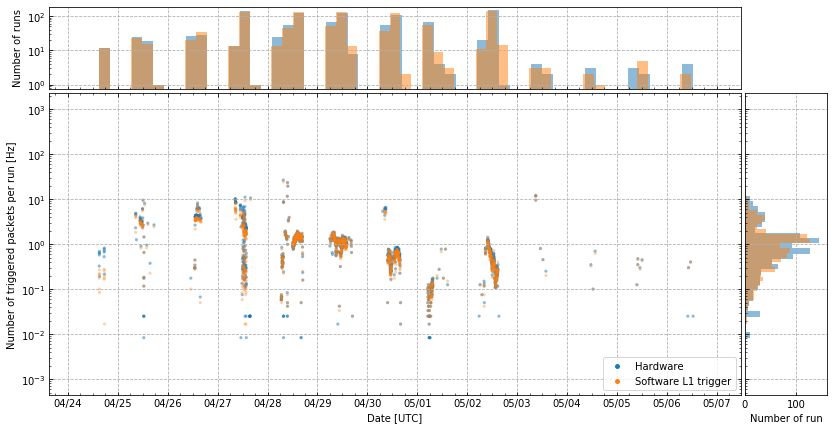

In [79]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
# gray

vis_trigger_rate_w_distributions(
    bgf05_file_trigger_datetimes_list,
    bgf05_trigger_rate_per_file_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Software L1 trigger', color='C1', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_bgf05.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);
# dodgerblue

#### All classified events

In [54]:
all_classified_trigger_datetime_list, all_classified_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan,  one_trg_per='packet')

1/987 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/987 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/987 allpackets-SPBEUSO-ACQUISITION-20170425-104043-001.001--CHECK.root
14/987 allpackets-SPBEUSO-ACQUISITION-20170425-104127-002

114/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-002.001--LONG-sqz.root
115/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-003.001--LONG-sqz-dis.root
116/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-003.001--LONG-sqz.root
117/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-004.001--LONG-sqz-dis.root
118/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-004.001--LONG-sqz.root
119/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-005.001--LONG-sqz-dis.root
120/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-005.001--LONG-sqz.root
121/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-006.001--LONG-sqz-dis.root
122/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-006.001--LONG-sqz.root
123/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz-dis.root
124/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz.root
125/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-008.001--LONG-sqz-dis.root
126/987 allpackets-SPBEUSO-ACQUISITION-2

217/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz-dis.root
218/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz.root
219/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-027.001--LONG-sqz-dis.root
220/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz-dis.root
221/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz.root
222/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz-dis.root
223/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz.root
224/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-030.001--LONG-sqz-dis.root
225/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-030.001--LONG-sqz.root
226/987 allpackets-SPBEUSO-ACQUISITION-20170427-154845-001.001--CHECK.root
227/987 allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root
 > SKIPPING
228/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-009.001--LONG.root
229/987 allpackets-SPBEUSO-ACQUISITION-20170428

327/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-006.001--LONG.root
328/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-007.001--LONG.root
329/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-008.001--LONG.root
330/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-009.001--LONG.root
331/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-010.001--LONG.root
332/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-011.001--LONG.root
333/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-012.001--LONG.root
334/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-013.001--LONG.root
335/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-014.001--LONG.root
336/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-015.001--LONG.root
337/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-016.001--LONG.root
338/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-017.001--LONG.root
339/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-018.001--LONG.root
340/987 allpackets-SPBEUSO-ACQUISITION

451/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-003.001--LONG.root
452/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-005.001--LONG-sqz.root
453/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-005.001--LONG.root
454/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-007.001--LONG.root
455/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-009.001--LONG-sqz.root
456/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-014.001--LONG-sqz.root
457/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-017.001--LONG-sqz.root
458/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-020.001--LONG.root
459/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-022.001--LONG.root
460/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-023.001--LONG-sqz.root
461/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-001.001--LONG-sqz.root
462/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-003.001--LONG.root
463/987 allpackets-SPBEUSO-ACQUISITION-20170429-100343-004.001--LONG.root
464/987 allpac

560/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-017.001--LONG-sqz.root
561/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-018.001--LONG-sqz.root
562/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-019.001--LONG-sqz.root
563/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-020.001--LONG-sqz.root
564/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-021.001--LONG-sqz.root
565/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-022.001--LONG-sqz.root
566/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-023.001--LONG-sqz.root
567/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-024.001--LONG-sqz.root
568/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-025.001--LONG-sqz.root
569/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-026.001--LONG-sqz.root
570/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-027.001--LONG-sqz.root
571/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-028.001--LONG-sqz.root
572/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-029.001--

683/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-007.001--LONG-sqz.root
684/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-008.001--LONG-sqz.root
685/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-009.001--LONG-sqz.root
686/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-010.001--LONG-sqz.root
687/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-011.001--LONG-sqz.root
688/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-012.001--LONG-sqz.root
689/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-013.001--LONG-sqz.root
690/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-014.001--LONG-sqz.root
691/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-016.001--LONG-sqz.root
692/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-017.001--LONG-sqz.root
693/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-018.001--LONG-sqz.root
694/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-019.001--LONG-sqz.root
695/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-020.001--

821/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-003.001--LONG-sqz.root
822/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-004.001--LONG-sqz.root
823/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-005.001--LONG-sqz.root
824/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-006.001--LONG-sqz.root
825/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-007.001--LONG-sqz.root
826/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-008.001--LONG-sqz.root
827/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-009.001--LONG-sqz.root
828/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-010.001--LONG-sqz.root
829/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-011.001--LONG-sqz.root
830/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-012.001--LONG-sqz.root
831/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-013.001--LONG-sqz.root
832/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-014.001--LONG-sqz.root
833/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-015.001--

965/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-024.001--LONG-sqz.root
966/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-025.001--LONG-sqz.root
967/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-026.001--LONG-sqz.root
968/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-027.001--LONG-sqz.root
969/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-028.001--LONG-sqz.root
970/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-029.001--LONG-sqz.root
971/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-030.001--LONG-sqz.root
972/987 allpackets-SPBEUSO-ACQUISITION-20170502-144913-001.001--CHECK.root
973/987 allpackets-SPBEUSO-ACQUISITION-20170503-085415-001.001--CHECK.root
974/987 allpackets-SPBEUSO-ACQUISITION-20170503-085728-001.001--CHECK.root
975/987 allpackets-SPBEUSO-ACQUISITION-20170503-090032-001.001--CHECK.root
976/987 allpackets-SPBEUSO-ACQUISITION-20170503-111308-001.001--CHECK.root
977/987 allpackets-SPBEUSO-ACQUISITION-20170503-122552-001.001--CHECK.root
978/

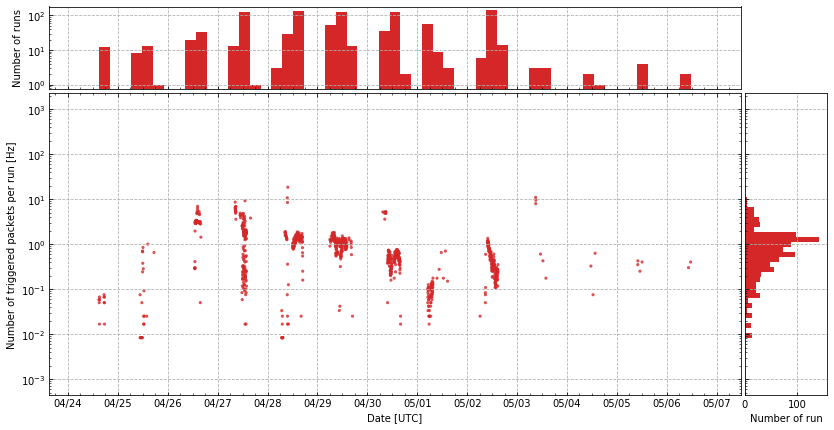

In [72]:
vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C3',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_all.png')
);
# limegreen

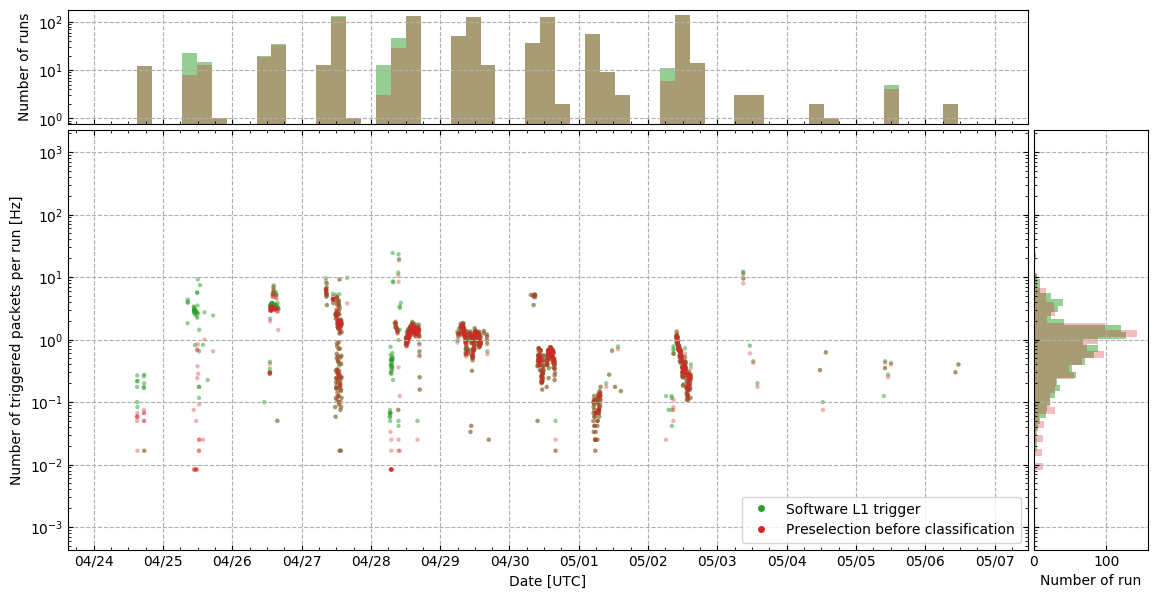

In [115]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        bgf05_file_trigger_datetimes_list,
        bgf05_trigger_rate_per_file_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Software L1 trigger', color='C2', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
#dodgerblue

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

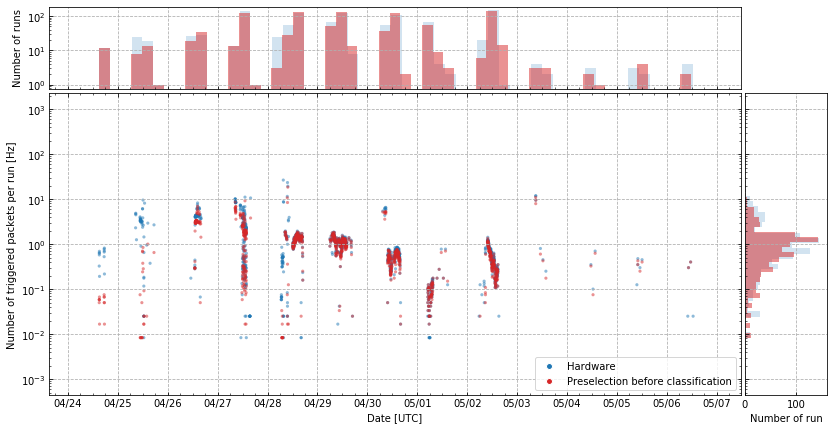

In [101]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.2, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Events classified as "air shower"

In [56]:
shower_trigger_datetime_list, shower_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan[flight_df_nonan[cls_column] == 1],  one_trg_per='packet')

1/274 allpackets-SPBEUSO-ACQUISITION-20170427-082510-001.001--CHECK.root
2/274 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG.root
3/274 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG.root
4/274 allpackets-SPBEUSO-ACQUISITION-20170427-105115-001.001--CHECK.root
5/274 allpackets-SPBEUSO-ACQUISITION-20170427-115219-001.001--CHECK.root
6/274 allpackets-SPBEUSO-ACQUISITION-20170427-125323-001.001--CHECK.root
7/274 allpackets-SPBEUSO-ACQUISITION-20170427-125407-002.001--LONG-sqz-dis.root
8/274 allpackets-SPBEUSO-ACQUISITION-20170427-125407-004.001--LONG-sqz-dis.root
9/274 allpackets-SPBEUSO-ACQUISITION-20170427-125407-014.001--LONG-sqz.root
10/274 allpackets-SPBEUSO-ACQUISITION-20170427-125407-019.001--LONG-sqz-dis.root
11/274 allpackets-SPBEUSO-ACQUISITION-20170427-125407-020.001--LONG-sqz-dis.root
12/274 allpackets-SPBEUSO-ACQUISITION-20170428-081641-001.001--CHECK.root
13/274 allpackets-SPBEUSO-ACQUISITION-20170428-081726-006.001--LONG.root
14/274 allpackets-S

129/274 allpackets-SPBEUSO-ACQUISITION-20170428-151019-022.001--LONG.root
130/274 allpackets-SPBEUSO-ACQUISITION-20170428-151019-023.001--LONG.root
131/274 allpackets-SPBEUSO-ACQUISITION-20170428-151019-024.001--LONG.root
132/274 allpackets-SPBEUSO-ACQUISITION-20170428-151019-026.001--LONG.root
133/274 allpackets-SPBEUSO-ACQUISITION-20170428-151019-027.001--LONG.root
134/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-002.001--LONG.root
135/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-004.001--LONG.root
136/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-005.001--LONG.root
137/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-006.001--LONG.root
138/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-007.001--LONG.root
139/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-009.001--LONG.root
140/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-010.001--LONG.root
141/274 allpackets-SPBEUSO-ACQUISITION-20170428-161317-011.001--LONG.root
142/274 allpackets-SPBEUSO-ACQUISITION

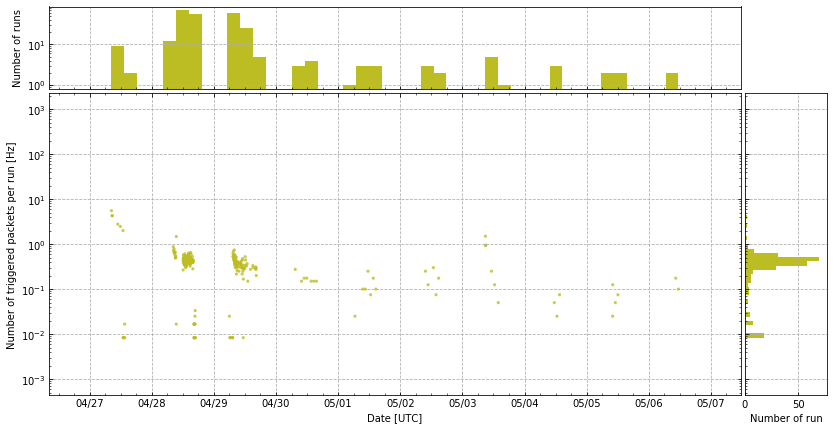

In [96]:
vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C8',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_air_shower.png')
);

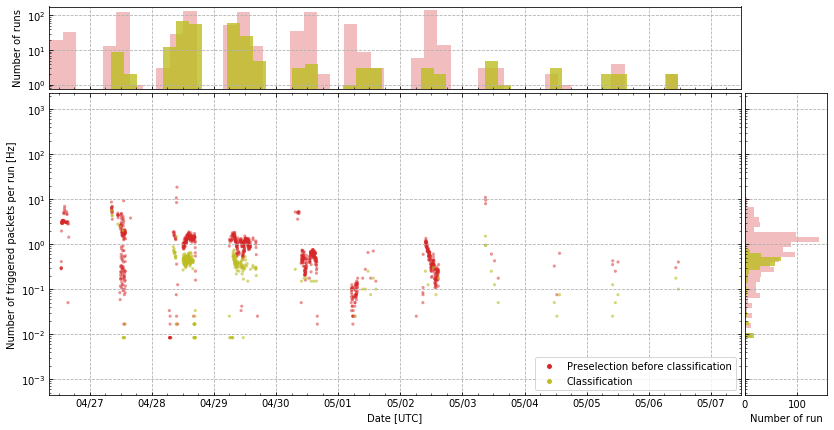

In [95]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        all_classified_trigger_datetime_list, 
        all_classified_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

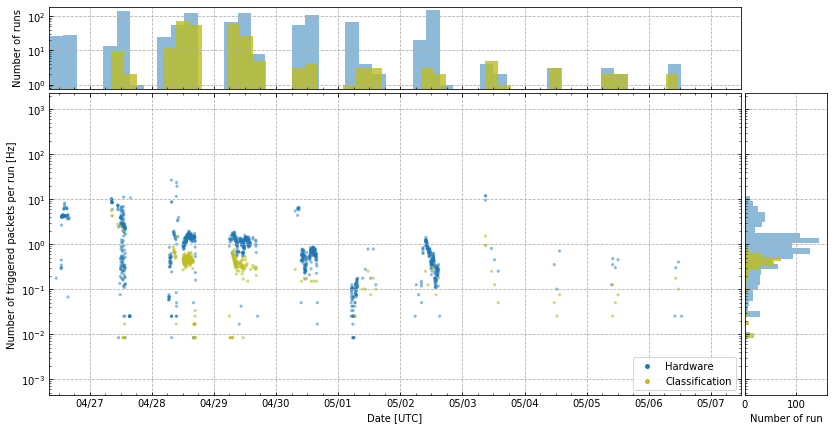

In [98]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

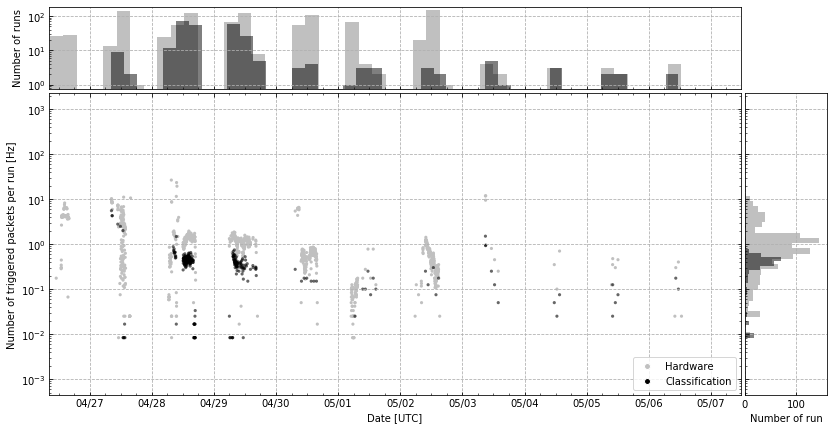

In [99]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='silver', hist_alpha=1, scatter_alpha=1,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='black', hist_alpha=.5, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected_bw.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Summary - mean trigger rate

In [116]:
print('Mean trigger rate in hardware data:          ', np.mean(hw_trigger_rate_per_file))
print('Mean trigger rate in feature-extracted data: ', np.mean(bgf05_trigger_rate_per_file_list))
print('Mean trigger rate in classified data:        ', np.mean(all_classified_trigger_rate_list))
print('Mean trigger rate in classifer selected data:', np.mean(shower_trigger_rate_list))

Mean trigger rate in hardware data:           1.448051447935921
Mean trigger rate in feature-extracted data:  1.3001118568232661
Mean trigger rate in classified data:         1.1126859364435429
Mean trigger rate in classifer selected data: 0.4336070559610706


### Distribution of classified events by manual classification

In [102]:
sns.set(style="whitegrid")

In [103]:
flight_df_nonan[manual_classification_class_name_column].value_counts()

unclassified              143713
dot                          454
top_left_ec                  353
blob                         300
noise                        255
bg_increased_suddenly        196
few_dots                     153
large_blob                   141
dot_w_blob_behind            133
bright_blob                   80
noise_with_week_dot           62
short_single_gtu_track        54
single_gtu_track              51
noise_unspecified             30
persistent_dot                29
cartesian_line                27
unspecified                   26
2pix_line                     24
blob_and_dots                 18
sparse_blobs                  14
storng_light                   3
Name: manual_classification_class_name, dtype: int64

Withount unclassified
All flight data in the selection


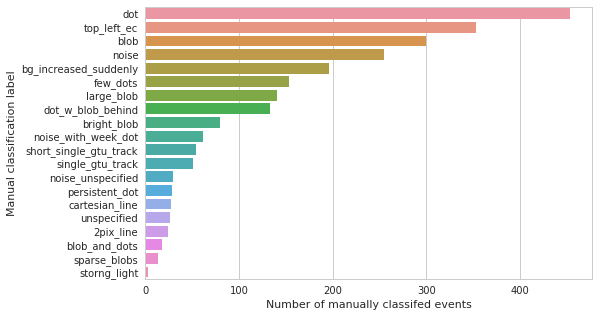

Events classified as positive


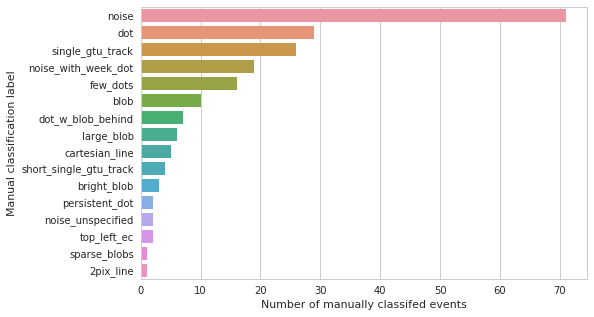

With unclassified
All flight data in the selection


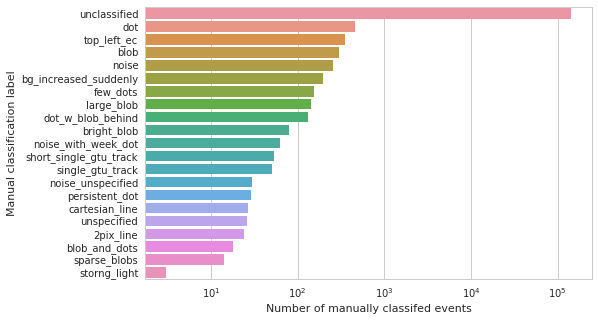

Events classified as positive


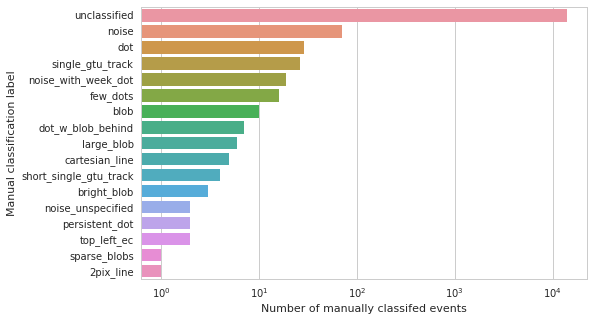

In [104]:
# requires manual_classification_class_name_column

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))
    
    for apply_air_shower_filter in [False, True]:
    
        print('Events classified as positive' if apply_air_shower_filter else 'All flight data in the selection')
    
        subset_df = \
            flight_df_nonan[flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']] \
            if not w_unclassified else \
            flight_df_nonan
    
        subset_df = subset_df[subset_df[cls_column] == 1] \
            if apply_air_shower_filter else subset_df
    
        fig, ax = plt.subplots(1, figsize=(8,5))
        sns.countplot(y=manual_classification_class_name_column, 
                      data=subset_df, ax=ax, orient='v',
                      order=subset_df[manual_classification_class_name_column].value_counts().index
                     )
        
        ax.set_ylabel('Manual classification label')
        ax.set_xlabel('Number of manually classifed events')

        flight_data_manual_classification_class_name_dist_fig_pathname = \
            os.path.join(
                data_snippets_dir, 
                'flight_data_manual_classification_class_name_distribution{}{}.svg'.format(
                    '_with_unclassified' if w_unclassified else '',
                    '_positive' if apply_air_shower_filter else ''
                ))

        if w_unclassified:
            ax.set_xscale('log')

        fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
        plt.show()
    
    print('='*50)

In [105]:
w_unclassified = False
apply_air_shower_filter = True

subset_df = \
    flight_df_nonan[
        flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
    ] if not w_unclassified else flight_df_nonan

print('All flight data in the selection')
print(subset_df.groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Events classified as positive')
print(subset_df[subset_df[cls_column] == 1].groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Ratios')

flight_data_nonan_class_ratios_df = \
    subset_df.groupby([manual_classification_class_name_column])[cls_column] \
        .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

flight_data_nonan_class_ratios_df #[flight_data_nonan_class_ratios_df[cls_column] == 1]

All flight data in the selection
manual_classification_class_name
2pix_line                  24
bg_increased_suddenly     196
blob                      300
blob_and_dots              18
bright_blob                80
cartesian_line             27
dot                       454
dot_w_blob_behind         133
few_dots                  153
large_blob                141
noise                     255
noise_unspecified          30
noise_with_week_dot        62
persistent_dot             29
short_single_gtu_track     54
single_gtu_track           51
sparse_blobs               14
storng_light                3
top_left_ec               353
unspecified                26
Name: event_id, dtype: int64
--------------------------------------------------
Events classified as positive
manual_classification_class_name
2pix_line                  1
blob                      10
bright_blob                3
cartesian_line             5
dot                       29
dot_w_blob_behind          7
few_dots         

,manual_classification_class_name,extra_trees_cls_on_train_rfecv_est_dropna,percentage
0,2pix_line,0,95.833333
33,top_left_ec,0,99.433428
32,storng_light,0,100.000000
30,sparse_blobs,0,92.857143
29,single_gtu_track,0,49.019608
26,short_single_gtu_track,0,92.592593
24,persistent_dot,0,93.103448
22,noise_with_week_dot,0,69.354839
20,noise_unspecified,0,93.333333
18,noise,0,72.156863


Withount unclassified


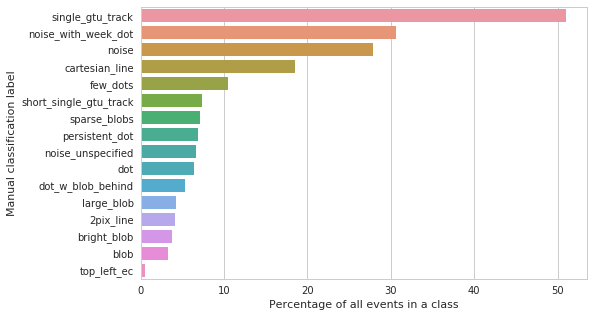

With unclassified


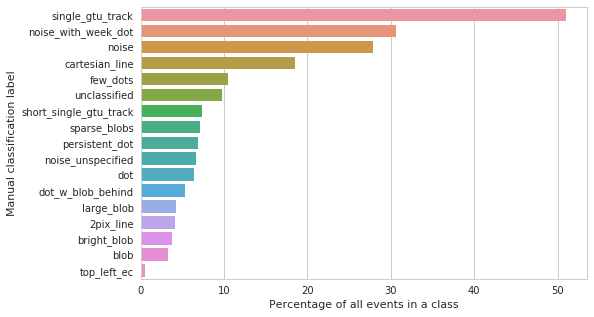

In [106]:
# flight_data_nonan_class_ratios_df

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = \
        flight_df_nonan[
            flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
        ] if not w_unclassified else flight_df_nonan

    flight_data_nonan_class_ratios_df = \
        subset_df.groupby([manual_classification_class_name_column])[cls_column] \
            .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

    fig, ax = plt.subplots(1, figsize=(8,5))

    subset_df = flight_data_nonan_class_ratios_df[flight_data_nonan_class_ratios_df[cls_column] == 1]
    
    p = sns.barplot(y=manual_classification_class_name_column, 
                    x="percentage", #hue=cls_column, 
                    data=subset_df, 
                    ax=ax, orient='h',
                    order=subset_df[manual_classification_class_name_column].iloc[
                        np.argsort(-subset_df["percentage"])]
                   )

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            'flight_data_manual_classification_class_name_normalized_distribution{}.svg'.format(
                '_with_unclassified' if w_unclassified else ''
            ))

#     if w_unclassified:
#         ax.set_xscale('log')

    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()

In [107]:
mpl.rcParams.update(mpl.rcParamsDefault)

### Saving flight data into tsv
(not in the report)

In [108]:
save_flight_data_dump_file = True
overwrite_flight_data_dump_file = False

In [109]:
if save_flight_data_dump_file:
    flight_data_tsv_pathname = os.path.join(data_snippets_dir, 'flight_data.tsv.gz')

    if overwrite_flight_data_dump_file or not os.path.exists(flight_data_tsv_pathname):
        print('Saving', flight_data_tsv_pathname)
        flight_df.to_csv(flight_data_tsv_pathname, sep='\t', compression='gzip')
    else:
        print('Already exists', flight_data_tsv_pathname)

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20190529_2/flight_data.tsv.gz


# Visualization of the events

## Visualizing the features

In [ ]:
flight_df_nonan[rfecv_selector_on_extra_trees__column_names + ['manual_classification_class_number']].head()

### Features used by the model

In [ ]:
len(rfecv_selector_on_extra_trees__column_names)

In [ ]:
importances = extra_trees_cls_on_train_rfecv_est.feature_importances_
indices = np.argsort(importances)[::-1]


rfecv_selector_on_extra_trees__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_extra_trees__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(len(rfecv_selector_on_extra_trees__column_names)) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for column_name, column_indice, column_importance in \
        rfecv_selector_on_extra_trees__column_names_indices_importances__sorted:
    print('{:<70}{:.4f}'.format(column_name,column_importance))


rfecv_selector_on_extra_trees__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

rfecv_selector_on_extra_trees__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

### Radvis

Presently not applied optimally, any useful output is not guarateed

In [ ]:
plt.close('all')
sns.set(style="whitegrid")

In [ ]:
plt.close('all')
for num_features in range(5,80,20):
    print('Number of features:\t{}'.format(num_features))
    f, ax = plt.subplots()
    f.set_size_inches(20,20)
    pd.plotting.radviz(
        flight_df_nonan[rfecv_selector_on_extra_trees__column_names__sorted[0:num_features] + ['manual_classification_class_name']], 
        'manual_classification_class_name', alpha=.8
    )
    plt.show()

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

## T-SNE

In [ ]:
%load_ext wurlitzer
# from sklearn.manifold import TSNE
import MulticoreTSNE
from sklearn.externals import joblib

In [ ]:
load_existing_tsne_model = True
refit_tsne_model = False
dump_tsne_embedding = True
show_plots = True

### Fitting

In [ ]:
tsne_hyperparams_dict = dict(
    learning_rate=100,
    n_iter=5000,
    perplexity=50, 
    angle=0.3,
    verbose=10,
    random_state=9621
)

In [ ]:
num_columns_list = list(range(25, len(rfecv_selector_on_extra_trees__column_names)+1, 25))

if (len(rfecv_selector_on_extra_trees__column_names)-25) % 25 != 0:
    num_columns_list += [len(rfecv_selector_on_extra_trees__column_names)]

In [ ]:
num_columns_list

In [ ]:
rfecv_selector_on_extra_trees__column_names__sorted

In [ ]:
tsne_hyperparams_dict_md5str = hashlib.md5(';'.join(['{}={}'.format(k,v) for k,v in sorted(tsne_hyperparams_dict.items())]).encode()).hexdigest()

flight_rfecv_columns__X_tsne_dict = {}
tsne_on_flight_nonan_rfecv_columns_X_pathname_dict = {}

for num_columns in num_columns_list:
    
    tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns] = \
        os.path.join(data_snippets_dir, 'tsne_flight_nonan__cfg_{}__{}_rfecv_columns__X.npy'.format(tsne_hyperparams_dict_md5str, num_columns))
    
    print('Fitting T-SNE of {} features'.format(num_columns))
    print('Pickled file pathname', tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])
    
    if refit_tsne_model or not os.path.exists(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns]):
        tsne_on_flight_nonan_rfecv_columns = MulticoreTSNE.MulticoreTSNE(**tsne_hyperparams_dict, n_jobs=10)
        flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.fit_transform(
            flight_rfecv_columns__X.T[rfecv_selector_on_extra_trees__column_indices__sorted[:num_columns+1]].T)
#         if dump_tsne_model: 
#             joblib.dump(tsne_on_flight_nonan_rfecv_columns, tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns], compress=1)
        if dump_tsne_embedding:
            np.save(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns], flight_rfecv_columns__X_tsne_dict[num_columns])
        
    else:
#         tsne_on_flight_nonan_rfecv_columns = joblib.load(tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns])
#         flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.embedding_
        flight_rfecv_columns__X_tsne_dict[num_columns] = np.load(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])

In [ ]:
for num_columns, X_tsne in flight_rfecv_columns__X_tsne_dict.items():
    
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    
    flight_df[x_col_prefix + 'X_0'] = np.nan
    flight_df[x_col_prefix + 'X_1'] = np.nan

    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), x_col_prefix + 'X_0'] = flight_rfecv_columns__X_tsne_dict[num_columns][:, 0]
    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), x_col_prefix + 'X_1'] = flight_rfecv_columns__X_tsne_dict[num_columns][:, 1]

# flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

### Updating `flight_df_nonan` with T-SNE dimension values
(not in the report)

In [ ]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

### Visualizing results of T-SNE

In [ ]:
EVENT_CLASSES

#### All classes in a single plot

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import data_analysis_utils

In [ ]:
def check_row_is_extra_trees_1(row, cls_column='extra_trees_cls_on_train_rfecv_est_dropna'):
    return r[cls_column] == 1

def add_tsne_shower_xy_axes(fig, scatter_plot_ax, df_nonan, annotation_side_frac, annotation_limit=None,
                            highlight_check_func=check_row_is_extra_trees_1, highlight_color='red', 
                            event_id_fontsize=8.5, event_id_color='red', cls_column='extra_trees_cls_on_train_rfecv_est_dropna', 
                            col_x0='tsne__X_0', col_x1='tsne__X_1', show_event_id=True):
        
    ax_lim_width = (scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0])
    annotation_side = annotation_side_frac*ax_lim_width

    shown_images = np.array([[1., 1.]])  # just something big
    
    for _i, (i, r) in enumerate(df_nonan.iterrows()):

        if _i % 10000 == 0:
            print('{}/{}'.format(_i, len(df_nonan)))

        dist = np.sqrt(np.sum(((r[col_x0], r[col_x1]) - shown_images) ** 2, 1))

        if np.min(dist) < annotation_side:
            continue

        shown_images = np.r_[shown_images, [ [r[col_x0], r[col_x1]] ]]

        axes_coords = [ 
            scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r[col_x0] - (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
            scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r[col_x1] - (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,

            annotation_side * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]), 
            annotation_side * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0])
        ]

        pax = fig.add_axes(axes_coords)
        if r[cls_column] == 1:
            pax.spines['bottom'].set_color(highlight_color)
            pax.spines['top'].set_color(highlight_color) 
            pax.spines['right'].set_color(highlight_color)
            pax.spines['left'].set_color(highlight_color)
        else:
            pax.set_axis_off()

        pax.set_xticks([])
        pax.set_yticks([])

        data_analysis_utils.visualize_single_event(
            r['source_file_acquisition_full'], 
            r['packet_id'], r['gtu_in_packet'], r['num_gtu'],
            ax_xy=pax, vis_gtux=False, vis_gtuy=False, draw_colorbar=False, 
            xlabel_xy=None, ylabel_xy=None, zlabel_xy=None,
            inverse_means_arr=inverse_means_map
        )
        
        if show_event_id:
            fig.text(
                scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r[col_x0] + (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
                scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r[col_x1] + (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,
                str(r['event_id']),
                fontsize=event_id_fontsize, color=event_id_color, ha='right', va='top', alpha=1
            )

#             print(r['source_file_acquisition_full'], r['packet_id'], r['gtu_in_packet'], r['num_gtu'], r[col_x0], r[col_x1], axes_coords)
#             print('-'*50)

        if annotation_limit is not None and _i > annotation_limit:
            break
        
    # end for

In [ ]:
# cm = plt.cm.nipy_spectral
# cm = plt.cm.gist_ncar
cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = ((0,0,0,1),)
marker_sequence = ['+', 'x', '1', '2', '3', '4']

recreate_plots = False

cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

for num_columns in num_columns_list:

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    num_columns_dirname = 'flight_data_feat_{}/all_classes_in_single'.format(num_columns)
    
    filename_prefix = 'flight_data_feat_{}_'.format(num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    for size_inches, do_unclassified, show_in_notebook, known_class_alpha, unclassified_class_alpha, scatter_s, \
        show_annotations, annotation_side_frac, show_event_id, annotation_limit, savefig_pathname  in (
            
            ((20,20), True, show_plots, 0.7, .02, 10,
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_20inch.png')),

            ((20,20), True, show_plots, 0.7, .02, 10,
             True, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_20inch.png')),

            ((40,40), True, False, 0.7, .02, 60,
             False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_40inch.png')),

            ((40,40), True, False, 0.7, .02, 60,
             True, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_40inch.png')),

            # following configuration is computationally demanding    
            ((200,200), True, False, 0.8, .1, 80,
             True, 0.006, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_200inch.png')),
    ):
        
        print('Size: {}, Pathname: {}'.format(str(size_inches), str(savefig_pathname)))
        
        if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists:', savefig_pathname)
            continue
        
        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

        tsne_scatter_labels_dict = {}
        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for ii, (class_name, class_number) in enumerate(sorted(EVENT_CLASSES.items(),key=lambda x: x[1])):
            if class_name == 'unclassified' and not do_unclassified:
                continue

            flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

            if len(flight_df_nonan_subset) <= 0:
                continue

            if class_name == 'unclassified':
                class_color = unclassified_class_color
                event_class_alpha = unclassified_class_alpha
            else:
                class_color = [cm(cm_norm(class_number))]
                event_class_alpha = known_class_alpha
            
            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', marker_sequence[ii % len(marker_sequence)])
            ):
                flight_df_nonan_subsubset = flight_df_nonan_subset[flight_df_nonan_subset[cls_column] == classification_class_num]
                
                pathcoll = ax.scatter(
                    flight_df_nonan_subsubset[col_x0], 
                    flight_df_nonan_subsubset[col_x1], 
                    c=class_color, 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=subset_marker
                )
                
                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color[0], markersize=10, marker=subset_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels_dict[pathcoll_for_legend] = \
                    (len(flight_df_nonan_subset), '{} ({})'.format(class_name, classification_class_name))
                
#                 print('> Adding to dict tsne_scatter_labels_dict, new len =', len(tsne_scatter_labels_dict), '{}{}{}{}{}'.format(class_color, scatter_s, subset_marker, 0, 'none'))
#                 tsne_scatter_labels.append('{} ({})'.format(class_name, classification_class_name))
#                 tsne_scatter_pathcolls.append(pathcoll_for_legend)

        if show_annotations:
            add_tsne_shower_xy_axes(f, ax, flight_df_nonan, annotation_side_frac, annotation_limit=annotation_limit, col_x0=col_x0, col_x1=col_x1)

#         ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname)

        if show_in_notebook:    
            plt.show()
                
        tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

        f, ax = plt.subplots()
        f.set_size_inches(15,6)

        ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
                  loc='center', fontsize='large', mode='expand', ncol=3)
        ax.set_axis_off()
            
        if savefig_pathname is not None:
            
            savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
            
            print('Saving figure: {}'.format(savefig_legend_pathname))
            f.savefig(savefig_legend_pathname)
        
        if show_in_notebook:    
            plt.show()
            

# flight_nonan__rfecv_columns_scaled_X__tsne

#### Unclassified and a single class

In [ ]:
cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'
single_class_event_class_alpha_dict = {'unclassified': .005}
single_class_event_class_alpha_default = 1

flight_df_nonan_subset_unclassified = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==EVENT_CLASSES['unclassified']]

cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = True

fig_dpi = 150
fig_size = (10,10)

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    filename_prefix = 'flight_data_feat_{}_'.format(num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    num_columns_dirname = 'flight_data_feat_{}/by_single_class'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

        if class_name == 'unclassified':
            continue

        flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

        if len(flight_df_nonan_subset) <= 0:
            continue
            
        savefig_pathname = os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_{}.png'.format(class_name))

        print('-'*30)
        print(class_name)
        print(savefig_pathname)
        print('-'*30)

        if os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists', savefig_pathname)
            continue

        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(fig_size)

        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for t_class_name, t_class_number, t_class_color, subset_df in (
                ('unclassified', EVENT_CLASSES['unclassified'], unclassified_class_color, flight_df_nonan_subset_unclassified), 
                (class_name, class_number, cm(cm_norm(class_number)), flight_df_nonan_subset)
        ):

            if t_class_name in single_class_event_class_alpha_dict:
                event_class_alpha = single_class_event_class_alpha_dict[t_class_name]
            else:
                event_class_alpha = single_class_event_class_alpha_default

            t_class_color_l = (t_class_color, )
                
            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', 'x')
            ):
                subsubset_df = subset_df[subset_df[cls_column]==classification_class_num]
                pathcoll = ax.scatter(
                    subsubset_df[col_x0], 
                    subsubset_df[col_x1], 
                    c=t_class_color_l, 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=subset_marker
                )

                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=t_class_color, markersize=10, marker=subset_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels.append('{} ({})'.format(t_class_name, classification_class_name))
                tsne_scatter_pathcolls.append(pathcoll_for_legend)

        ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)
        
        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=fig_dpi)
        
        if show_in_notebook:
            plt.show()

# flight_nonan__rfecv_columns_scaled_X__tsne

### T-SNE Data after classification

In [ ]:
cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

cm = plt.cm.coolwarm
event_classes_for_cm = [flight_df_nonan[cls_column].min(), flight_df_nonan[cls_column].max()]
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
# unclassified_class_color = 'black'
unclassified_class_marker='x'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = False

fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    filename_prefix = 'flight_data_feat_{}_'.format(num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    num_columns_dirname = 'flight_data_feat_{}/by_classification_result'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    for size_inches, show_in_notebook, known_class_alpha, unclassified_class_alpha, print_counts, \
        show_annotations, annotation_side_frac, show_event_id, annotation_limit, savefig_pathname  in (
            ((15, 15), show_in_notebook, (0.5, 0.7), (0.01, 0.06), True, 
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_low_intensity_shower_15_inches.png')),
            ((15, 15), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_high_intensity_shower_15_inches.png')),
            ((20, 20), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
             True, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_20_inches.png')),
            ((40, 40), False, (0.6, 0.7), (0.05, 0.6), False, 
             False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_40_inches.png')),
            ((40, 40), False, (0.6, 0.7), (0.05, 0.6), False, 
             True, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_40_inches.png')),
    #       following configuration is computationally and I/O  demanding    
            ((200,200),  False, (0.8, 1), (0.1, 0.8), False, 
             True, 0.006, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_200_inches.png')),
    ):
        
        print('Size: {}, show annotations: {}'.format(str(size_inches), str(show_annotations)))
        
        if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists:', savefig_pathname)
            continue
        
        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

#         tsne_scatter_labels = []
#         tsne_scatter_pathcolls = []
        tsne_scatter_labels_dict = {}

        for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):
            if print_counts:
                print('Class: {}'.format(class_name))

            for cls_est_value in event_classes_for_cm:

                flight_df_nonan_subset = flight_df_nonan[
                    (flight_df_nonan['manual_classification_class_number']==class_number) & \
                    (flight_df_nonan[cls_column]==cls_est_value)
                ]

                if print_counts:
                    print('  classified {}: {} events'.format(
                        'shower' if cls_est_value == 1 else 'noise', 
                        len(flight_df_nonan_subset)))

                if len(flight_df_nonan_subset) <= 0:
                    continue

                if class_name == 'unclassified':
                    event_class_alpha = unclassified_class_alpha[cls_est_value]
                    class_marker = unclassified_class_marker
                else:
                    event_class_alpha = known_class_alpha[cls_est_value]
                    class_marker = '${}$'.format(class_number)

                class_color = cm(cm_norm(cls_est_value))

                pathcoll = ax.scatter(
                    flight_df_nonan_subset[col_x0], 
                    flight_df_nonan_subset[col_x1], 
                    c=[class_color], 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=class_marker
                )

                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color, markersize=10, marker=class_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels_dict[pathcoll_for_legend] = \
                    (len(flight_df_nonan_subset), '{} ({}: {})'.format(
                    class_name, 
                    'air shower' if cls_est_value==1 else 'noise',
                     len(flight_df_nonan_subset)
                ))
                
        if show_annotations:
            add_tsne_shower_xy_axes(
                f, ax, 
                flight_df_nonan[flight_df_nonan[cls_column]==1], 
                annotation_side_frac, annotation_limit=annotation_limit, col_x0=col_x0, col_x1=col_x1, show_event_id=show_event_id)

        
        ax.legend(
            [mpl.lines.Line2D(range(1),range(1), 
                              color=cm(cm_norm(cls_est_value)), 
                              markersize=10, marker=unclassified_class_marker,
                              linewidth=1,  linestyle='none') \
                   for cls_est_value in event_classes_for_cm],
            ['air shower prediction', 'noise prediction'], fontsize='large', 
        #    loc='center', mode='expand', ncol=3
        )
            
        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=fig_dpi)

        if show_in_notebook:
            plt.show()
        
        tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

        f, ax = plt.subplots()
        f.set_size_inches(15,6)

        ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
                  loc='center', fontsize='large', mode='expand', ncol=3)
        ax.set_axis_off()
            
        if savefig_pathname is not None:
            
            savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
            
            print('Saving figure: {}'.format(savefig_legend_pathname))
            f.savefig(savefig_legend_pathname, dpi=fig_dpi)
        
        if show_in_notebook:    
            plt.show()
    
# flight_nonan__rfecv_columns_scaled_X__tsne

## Clustering T-SNE data

In [ ]:
import sklearn.cluster
# from sklearn import cluster, datasets, mixture

In [ ]:
def davies_bouldin_score(X, labels):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.utils import safe_indexing, check_X_y
    from sklearn.metrics.cluster.unsupervised import check_number_of_labels
    from sklearn.metrics.pairwise import pairwise_distances
    # form 0.20
    X, labels = check_X_y(X, labels)
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples, _ = X.shape
    n_labels = len(le.classes_)
    check_number_of_labels(n_labels, n_samples)

    intra_dists = np.zeros(n_labels)
    centroids = np.zeros((n_labels, len(X[0])), dtype=np.float)
    for k in range(n_labels):
        cluster_k = safe_indexing(X, labels == k)
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(pairwise_distances(
            cluster_k, [centroid]))

    centroid_distances = pairwise_distances(centroids)

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0

    score = (intra_dists[:, None] + intra_dists) / centroid_distances
    score[score == np.inf] = np.nan
    return np.mean(np.nanmax(score, axis=1))


### DBSCAN clustering

#### Comparison of different scoring methods in relation to EPS

In [ ]:
# eps_list = []
# eps_num_clusters_list = []
# silhouette_score_list = []
# calinski_harabaz_score_list = []
# davies_bouldin_score_list = []

# for eps_v in np.arange(1-0.4,3.4,0.1):
#     print(eps_v)
#     eps_list.append(eps_v)
#     dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_v, algorithm='ball_tree')
#     flight_nonan__tsne__dbscan_y_pred = dbscan_on_tsne.fit_predict(flight_df_nonan[[col_x0,col_x1]].values)
    
#     eps_num_clusters_list.append(len(np.unique(flight_nonan__tsne__dbscan_y_pred)))
    
#     print(' > len(clusters) =', eps_num_clusters_list[-1])

#     silhouette_score_list.append(
#         sklearn.metrics.silhouette_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred, sample_size=10000)
#     )
#     print(' > silhouette_score =', silhouette_score_list[-1])
#     calinski_harabaz_score_list.append(
#         sklearn.metrics.calinski_harabaz_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred)
#     )
#     print(' > calinski_harabaz_score =', calinski_harabaz_score_list[-1])
#     davies_bouldin_score_list.append(
#         davies_bouldin_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred)
#     )
#     print(' > davies_bouldin_score = ', davies_bouldin_score_list[-1])

In [ ]:
# fig, axs = plt.subplots(2,1, sharex=True, constrained_layout=True)
# fig.set_size_inches(10,4*2)
# axs[0].plot(eps_list, eps_num_clusters_list, label='Cluster size')
# axs[0].legend()
# axs[0].set_ylabel('Cluster size')
# axs[1].plot(eps_list, (np.array(silhouette_score_list)-np.min(silhouette_score_list))/(np.max(silhouette_score_list)-np.min(silhouette_score_list)), label='silhouette_score_list')  
# axs[1].plot(eps_list, (np.array(calinski_harabaz_score_list)-np.min(calinski_harabaz_score_list))/(np.max(calinski_harabaz_score_list)-np.min(calinski_harabaz_score_list)), label='calinski_harabaz_score_list')  
# axs[1].plot(eps_list, (np.array(davies_bouldin_score_list)-np.min(davies_bouldin_score_list))/(np.max(davies_bouldin_score_list)-np.min(davies_bouldin_score_list)), label='davies_bouldin_score_list')  
# axs[1].set_ylabel('Normalized score')
# axs[1].set_xlabel('EPS')
# axs[1].legend()
# plt.show()

#### Optimization to find an optimal EPS according to the scoring method

The scoring method mught not be optimal, the goal was to make it more systematic than a guessed value.

In [ ]:
# from scipy.optimize import minimize as sp_opt_minimize
# from scipy.optimize import minimize_scalar as sp_opt_minimize_scalar

In [ ]:
# def cluster_data_fun(eps_v, vals_arr):
#     dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_v, algorithm='ball_tree')
#     pred_arr = dbscan_on_tsne.fit_predict(vals_arr)
    
#     calinski_harabaz_score = \
#         sklearn.metrics.calinski_harabaz_score(vals_arr, pred_arr)
    
# #     print('eps_v =', eps_v, 'calinski_harabaz_score=', calinski_harabaz_score)
    
#     return 1/calinski_harabaz_score

In [ ]:
# rerun_dbcan_eps_optimization = False

In [ ]:
# dbscan_eps_dict_plk_pathname = os.path.join(data_snippets_dir, 'dbscan_eps_dict.pkl')
# optimzer_minimize_bonds = (0.5, 5.5)
 
# _dbscan_eps_dict_plk_pathname_exists = os.path.exists(dbscan_eps_dict_plk_pathname)

dbscan_eps_dict = {}

# for now using constatnt eps value, optimization was not satisfactory

for num_columns in num_columns_list:
    dbscan_eps_dict[num_columns] = 1.9

# if not rerun_dbcan_eps_optimization and _dbscan_eps_dict_plk_pathname_exists:
#     print('Loading:', dbscan_eps_dict_plk_pathname)
#     dbscan_eps_dict = joblib.load(dbscan_eps_dict_plk_pathname)

# if rerun_dbcan_eps_optimization or not _dbscan_eps_dict_plk_pathname_exists \
#         or np.any([not (n in dbscan_eps_dict) for n in num_columns_list]): 
    
#     for num_columns in num_columns_list:

#         print('-'*50)
#         print('T-SNE on {} features'.format(num_columns))
#         print('-'*50)
    
#         if not rerun_dbcan_eps_optimization and num_columns in dbscan_eps_dict:
#             print('Already available:', dbscan_eps_dict[num_columns])
#             continue
        
#         col_prefix = 'tsne_{}_feat__'.format(num_columns)
#         col_x0 = col_prefix + 'X_0'
#         col_x1 = col_prefix + 'X_1'
#         col_dbscan_y = col_prefix + 'dbscan_y'

#         # opt_res = sp_opt_minimize(cluster_data_fun, 1.6, args=(flight_df_nonan[[col_x0,col_x1]].values),
#         #                           bounds=[(0.5, 10)], method='Nelder-Mead')

#         opt_res = sp_opt_minimize_scalar(cluster_data_fun, args=(flight_df_nonan[[col_x0,col_x1]].values), 
#                                          bounds=optimzer_minimize_bonds, method='bounded', options=dict(maxiter=50))
  
#         print('x: {}; success: {}; status: {}; message: {}'.format(
#             opt_res.x, opt_res.success, opt_res.status, opt_res.message))
        
#         dbscan_eps_dict[num_columns] = opt_res.x
    
#     print('Saving:', dbscan_eps_dict_plk_pathname)
    
#     joblib.dump(dbscan_eps_dict, dbscan_eps_dict_plk_pathname)

for num_columns in num_columns_list:
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'
    
    eps_value = dbscan_eps_dict[num_columns]
        
    dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_value, algorithm='ball_tree')
    flight_nonan__tsne__dbscan_y_pred = dbscan_on_tsne.fit_predict(flight_df_nonan[[col_x0,col_x1]].values)
    
    flight_df[col_dbscan_y] = np.nan
    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), col_dbscan_y] = flight_nonan__tsne__dbscan_y_pred
    
    dbscan_on_tsne_classes = np.unique(flight_nonan__tsne__dbscan_y_pred)

    print('EPS:', eps_value)
    print('Number of clusters:', len(dbscan_on_tsne_classes))

#### Updating `flight_df_nonan` with cluster numbers
(not in the report)

In [ ]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

#### Visualization of the clusters

In [ ]:
plt.close('all')

recreate_plots = True

dbscan_cm = plt.cm.gist_rainbow
# dbscan_cm = plt.cm.prism
dbscan_on_tsne_classes_for_cm = [v for v in dbscan_on_tsne_classes if v > 0]
dbscan_cm_norm = mpl.colors.Normalize(min(dbscan_on_tsne_classes_for_cm),max(dbscan_on_tsne_classes_for_cm))
dbscan_unclassified_class_color = 'black'

event_class_alpha = 0.1

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (20, 20)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}/dbscan_clusters'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
        
    savefig_pathname = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}.png'.format(num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    plt.close('all')
        
    f, ax = plt.subplots()
    f.set_size_inches(fig_size)

    tsne_scatter_labels_dict = {}

    for cluster_number in sorted(dbscan_on_tsne_classes):

        flight_df_nonan_subset = flight_df_nonan[flight_df_nonan[col_dbscan_y]==cluster_number]

        if len(flight_df_nonan_subset) <= 0:
            continue

        if cluster_number < 0:
            class_color = dbscan_unclassified_class_color
        else:
            class_color = dbscan_cm(dbscan_cm_norm(cluster_number))

        class_marker = '${:d}$'.format(cluster_number)

        pathcoll = ax.scatter(
            flight_df_nonan_subset[col_x0], 
            flight_df_nonan_subset[col_x1], 
            c=[class_color], 
            s=80, linewidths=0,
            alpha=event_class_alpha,
            marker=class_marker
        )

        pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                               color=class_color, markersize=10, marker=class_marker,
                                               linewidth=1,  linestyle='none')

        tsne_scatter_labels_dict[pathcoll_for_legend] = \
            (len(flight_df_nonan_subset), '{} ({})'.format(cluster_number, len(flight_df_nonan_subset)))


    if savefig_pathname is not None:
        print('Saving figure: {}'.format(savefig_pathname))
        f.savefig(savefig_pathname, dpi=fig_dpi)

    if show_in_notebook:
        plt.show()

    tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

    f, ax = plt.subplots()
    f.set_size_inches(15,6)

    ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
              loc='center', fontsize='large', mode='expand', ncol=8)
    ax.set_axis_off()
    
    if savefig_pathname is not None:
        savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
        print('Saving figure: {}'.format(savefig_legend_pathname))
        f.savefig(savefig_legend_pathname, dpi=fig_dpi)

    if show_in_notebook:
        plt.show()

#### Cluster membership distribution

In [ ]:
recreate_plots = True

num_columns_shown_in_notebook =  [True] * len(num_columns_list)
# num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (20, 4)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_dbscan_y = 'tsne_{}_feat__dbscan_y'.format(num_columns)

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    savefig_pathname_format = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}_{{}}_cluster_membership.png'.format(num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    dbscan_on_tsne_classes_range = np.max(dbscan_on_tsne_classes) - np.min(dbscan_on_tsne_classes)
    
    plt.close('all')
    
    for yscale in ['log','linear']:
        f, ax = plt.subplots()
        f.set_size_inches(*fig_size)
        ax.set_yscale(yscale)
        
        flight_df_nonan[col_dbscan_y].hist(
            ax=ax, bins=2*dbscan_on_tsne_classes_range+2, 
            range=(np.min(dbscan_on_tsne_classes), np.max(dbscan_on_tsne_classes)+1))
        
        ax.set_xlabel('Cluster number')
        ax.set_ylabel('Number of events')
        
        savefig_pathname = savefig_pathname_format.format(yscale)

        if show_in_notebook:
            plt.show()

#### Cluster size distibution

In [ ]:
recreate_plots = True

num_columns_shown_in_notebook =  [True] * len(num_columns_list)
# num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (10,4)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_dbscan_y = 'tsne_{}_feat__dbscan_y'.format(num_columns)

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
        
    savefig_pathname = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}_cluster_size_distribution.png'.format(
            num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    plt.close('all')
        
    f, ax = plt.subplots(figsize=fig_size)
    flight_df_nonan[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count()['event_id'].hist(bins=200, ax=ax) 
    ax.set_xlabel('Cluster size')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    # ax.set_xscale('log')
    
    if savefig_pathname is not None and (not os.path.exists(savefig_pathname) or recreate_plots):
        f.savefig(savefig_pathname)
    
    if show_in_notebook:
        plt.show()

##### Number of events in a cluster by a class of an event

In [ ]:
# cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[-1] = show_plots

scatter_fig_size = (15, 15)
hist_fig_size = (15, 2.5)
fig_dpi = 150

recreate_plots = True

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}/dbscan_cluster_numbers_by_event_class'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    tsne_X_0_range = np.min(flight_df_nonan[col_x0]), np.max(flight_df_nonan[col_x0])
    tsne_X_1_range = np.min(flight_df_nonan[col_x1]), np.max(flight_df_nonan[col_x1])

    single_class_event_class_alpha_dict = {'unclassified': .01}
    single_class_event_class_alpha_default = 1

    dbscan_on_tsne_classes_range = np.max(dbscan_on_tsne_classes) - np.min(dbscan_on_tsne_classes)

    for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

        flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

        print('-'*30)
        print('  {} ({})'.format(class_name, len(flight_df_nonan_subset)))
        print('-'*30)

        savefig_pathname_format = os.path.join(
            data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_tsne_dbscan_{}_clusters_for_{}_{{}}.{{}}'.format(
                num_columns, '{:.2f}'.format(eps_value).replace('.', '_'), class_name))

        hist_savefig_pathname = savefig_pathname_format.format('cluster_number_hist', 'svg')
        scatter_savefig_pathname = savefig_pathname_format.format('scatter', 'png')
        entries_per_class_file_pathname = savefig_pathname_format.format('entries_per_class', 'txt')

#         if np.all([p is not None and os.path.exists(p) for p in (
#                 hist_savefig_pathname, scatter_savefig_pathname, entries_per_class_file_pathname
#             )]) and \
#                 not show_in_notebook and not recreate_plots:
#             print('Already exists:', savefig_pathname)
#             continue
         
        plt.close('all')
        
        with open(entries_per_class_file_pathname, 'w') as entries_per_class_file:

            print('-'*30, file=entries_per_class_file)
            print('  {} ({})'.format(class_name, len(flight_df_nonan_subset)), file=entries_per_class_file)
            print('-'*30, file=entries_per_class_file)
            
            if len(flight_df_nonan_subset) <= 0:
                print('Empty')
                continue

            unsorted_cluster_numbers_str = '  ' + \
                '  '.join('{:3d} ({:5d}){}'.format(cluster_number, r['event_id'], '\n' if (i+1) % 10 == 0 else '') \
                    for i, (cluster_number, r) in enumerate(flight_df_nonan_subset[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count().iterrows()))

            sorted_cluster_numbers_str = '  ' + \
                '  '.join('{:3d} ({:5d}){}'.format(cluster_number, r['event_id'], '\n' if (i+1) % 10 == 0 else '') \
                        for i, (cluster_number, r) in \
                            enumerate(sorted(flight_df_nonan_subset[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count().iterrows(), 
                                   key=lambda x: x[1]['event_id'], reverse=True)))
            
            for f in (sys.stdout, entries_per_class_file):
                print(unsorted_cluster_numbers_str, file=f)

                if unsorted_cluster_numbers_str != sorted_cluster_numbers_str:
                    print('  Sorted:', file=f)
                    print(sorted_cluster_numbers_str, file=f)
            
        save_hist_plot = hist_savefig_pathname is not None and (not os.path.exists(hist_savefig_pathname) or recreate_plots)

        if show_in_notebook or save_hist_plot:

            f, ax = plt.subplots(figsize=hist_fig_size)
            flight_df_nonan_subset[col_dbscan_y].hist(ax=ax, bins=2*dbscan_on_tsne_classes_range+2, 
                                                         range=(np.min(dbscan_on_tsne_classes), np.max(dbscan_on_tsne_classes)+1))
            ax.set_xlabel('Cluster number')
            ax.set_ylabel('Number of events')
            ax.set_title('Cluster numbers for class "{}"'.format(class_name))

            if save_hist_plot:
                print('Saving plot', hist_savefig_pathname)
                f.savefig(hist_savefig_pathname, dpi=fig_dpi)

            if show_in_notebook:
                plt.show()

        if class_name != 'unclassified':

            save_scatter_plot = scatter_savefig_pathname is not None and (not os.path.exists(scatter_savefig_pathname) or recreate_plots)

            if show_in_notebook or save_scatter_plot:
                f, ax = plt.subplots(figsize=scatter_fig_size)
                ax.set_xlim(*tsne_X_0_range)
                ax.set_ylim(*tsne_X_1_range)

            else:
                f, ax = None, None

            tsne_scatter_labels = []
            tsne_scatter_pathcolls = []

            for cluster_number in flight_df_nonan_subset[col_dbscan_y].unique():
        #         print(cluster_number)

                flight_df_nonan_subset_other = flight_df_nonan[(flight_df_nonan['manual_classification_class_number'] != class_number) & (flight_df_nonan[col_dbscan_y] == cluster_number)]
                flight_df_nonan_subsubset = flight_df_nonan_subset[(flight_df_nonan_subset[col_dbscan_y] == cluster_number)]

                for subset_df, t_class_name, event_class_alpha, t_class_color in (
                    (flight_df_nonan_subset_other, 'Other classes', single_class_event_class_alpha_dict['unclassified'], unclassified_class_color),
                    (flight_df_nonan_subsubset, class_name, single_class_event_class_alpha_default, cm(cm_norm(class_number)))
                ):
        #             print('  -',t_class_name,len(subset_df))

                    if len(subset_df) <= 0:
                        continue

                    for classification_class_num, classification_class_name, subset_marker in (
                        (1, 'shower est.', 'o'), (0, 'noise est.', '${}$'.format(cluster_number))
                    ):  
                        subsubset_df = subset_df[subset_df[cls_column]==classification_class_num]

        #                 print('    -',classification_class_name, len(subsubset_df))

                        if show_in_notebook or save_scatter_plot:

                            pathcoll = ax.scatter(
                                subsubset_df[col_x0], 
                                subsubset_df[col_x1], 
                                c=[t_class_color], 
                                s=80, linewidths=0,
                                alpha=event_class_alpha,
                                marker=subset_marker
                            )

        #                 if class_name != 'unclassified':
        #                     tsne_scatter_labels.append('{}: {} ({})'.format(cluster_number, t_class_name, classification_class_name))
        #                     tsne_scatter_pathcolls.append(pathcoll)
        #     ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

            if save_scatter_plot:
                print('Saving plot', scatter_savefig_pathname)
                f.savefig(scatter_savefig_pathname, dpi=fig_dpi)   

            if show_in_notebook:
                plt.show()
    

##### Number of event classes by a cluster

In [ ]:
small_cluster_threshold = 5  # number of events, if less cluster is not visualized

In [ ]:
clusters_visualized = {}
clusters_small = {}
clusters_empty = []

for num_columns in num_columns_list:

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_dbscan_y = col_prefix + 'dbscan_y'
    
    for cluster_number in sorted(dbscan_on_tsne_classes):

        flight_df_nonan_subset = flight_df_nonan[
            (flight_df_nonan[col_dbscan_y]==cluster_number) & \
            (flight_df_nonan['manual_classification_class_number'] != EVENT_CLASSES['unclassified'])
        ]

        if len(flight_df_nonan_subset) <= 0:
            clusters_empty.append(cluster_number)
        elif len(flight_df_nonan_subset) < small_cluster_threshold:
            clusters_small[cluster_number] = len(flight_df_nonan_subset) 
        else:
            clusters_visualized[cluster_number] = len(flight_df_nonan_subset) 

    print('Num. empty clusters: ', len(clusters_empty))
    print()
    print(', '.join(str(c) for c in clusters_empty))
    print('-'*80)
    print()

    for dataset_name, dataset_dict in (('small', clusters_small), 
                                       ('visualized', clusters_visualized)):
        print('Num. {} clusters: {}'.format(dataset_name, len(dataset_dict)))
        print()

        for cluster_number, subset_len in sorted(dataset_dict.items(), key=lambda x: x[1], reverse=True):
            cluster_events = flight_df_nonan[flight_df_nonan[col_dbscan_y]==cluster_number]
            cluster_classes_counts = \
                cluster_events[
                    cluster_events['manual_classification_class_number'] != EVENT_CLASSES['unclassified']
                ][['event_id', 'manual_classification_class_number']] \
                    .groupby('manual_classification_class_number').count() \
                    .sort_values('event_id',ascending=False)

            print('\t{:<5d} -  {:>3} classified ev, {:>2} unique ev classes, {:>5} ev in cluster  '.format(
                cluster_number, subset_len, len(cluster_classes_counts), len(cluster_events),
            ))
            print()
            print('\t      --   ' +
            ', '.join('{} ({})'.format(INVERSE_EVENT_CLASSES[class_number],r['event_id']) for class_number, r in \
                          cluster_classes_counts.head(small_cluster_threshold).iterrows()),
                '...' if len(cluster_classes_counts) > small_cluster_threshold else ''
            )
            print('\n')

        print('-'*80)
        print()

In [ ]:
cls_column = 'extra_trees_cls_on_train_rfecv_est_dropna'

cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'

single_class_event_class_alpha_dict = {'unclassified': .01}
single_class_event_class_alpha_default = 0.7

event_class_numbers = list([v for k, v in EVENT_CLASSES.items() if k != 'unclassified'])
event_class_numbers_range = np.max(event_class_numbers) - np.min(event_class_numbers)

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = False

scatter_fig_size = (15, 15)
barplot_fig_size = (15, 2.5)
fig_dpi = 150


class_sizes_ser = \
    flight_df_nonan[flight_df_nonan['manual_classification_class_number']!=EVENT_CLASSES['unclassified']] \
        [['event_id','manual_classification_class_number']] \
            .groupby('manual_classification_class_number') \
            .count()['event_id']


print(class_sizes_ser)


for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data_feat_{}/dbscan_event_classes_by_cluster_number'.format(num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    tsne_X_0_range = np.min(flight_df_nonan[col_x0]), np.max(flight_df_nonan[col_x0])
    tsne_X_1_range = np.min(flight_df_nonan[col_x1]), np.max(flight_df_nonan[col_x1])

    barplot_ind = np.arange(len(event_class_numbers))
    # barplot_xlabels = [INVERSE_EVENT_CLASSES[v] for v in event_class_numbers]
    # '#{}: {}'.format(v, INVERSE_EVENT_CLASSES[v])

    for cluster_number in sorted(dbscan_on_tsne_classes):
        
        savefig_pathname_format = os.path.join(
            data_snippets_dir, num_columns_dirname, 'flight_data_feat_{}_manual_cls_classes_for_tsne_dbscan_{}_cluster_{}_{{}}.{{}}'.format(
                num_columns, '{:.2f}'.format(eps_value).replace('.', '_'), cluster_number))

        barplot_savefig_pathname_format = savefig_pathname_format.format('manual_classes_barplot_{}_yaxis', 'svg')
        
        barplot_savefig_pathname_raw = barplot_savefig_pathname_format.format('raw')
        barplot_savefig_pathname_normalized = barplot_savefig_pathname_format.format('normalized')
        barplot_savefig_pathname_normalized_all = barplot_savefig_pathname_format.format('normalized_all')
        barplot_savefig_pathname_normalized_weighted_all = barplot_savefig_pathname_format.format('normalized_weighted_all')
        
        scatter_savefig_pathname = savefig_pathname_format.format('scatter', 'png')
        entries_per_cluster_file_pathname = savefig_pathname_format.format('entries_per_cluster', 'txt')
        

#         if np.all([p is not None and os.path.exists(p) for p in (
#                 hist_savefig_pathname, scatter_savefig_pathname, entries_per_class_file_pathname
#             )]) and \
#                 not show_in_notebook and not recreate_plots:
#             print('Already exists:', savefig_pathname)
#             continue

        cluster_events_df = flight_df_nonan[flight_df_nonan[col_dbscan_y]==cluster_number]

        cluster_classes_counts = \
            cluster_events_df[
                cluster_events_df['manual_classification_class_number'] != EVENT_CLASSES['unclassified']
            ][['event_id', 'manual_classification_class_number']] \
                .groupby('manual_classification_class_number').count() \
    #             .sort_values('event_id',ascending=False)  # intentionally not sorted

        flight_df_nonan_subset = \
            cluster_events_df[cluster_events_df['manual_classification_class_number'] != EVENT_CLASSES['unclassified']]

        flight_df_nonan_subset_unclassified = \
            cluster_events_df[cluster_events_df['manual_classification_class_number'] == EVENT_CLASSES['unclassified']]
        
        with open(entries_per_cluster_file_pathname, 'w') as entries_per_cluster_file:
            for f in (sys.stdout, entries_per_cluster_file):
                print('-'*80, file=f)
                print('Cluster {:<5d} -  {:>3} classified events, {:>2} unique event classes, {:>5} events in cluster'.format(
                    cluster_number, len(flight_df_nonan_subset), len(cluster_classes_counts), len(cluster_events_df)
                ), file=f)
                print()

                if len(flight_df_nonan_subset) <= 0:
                    print('\t      --   Empty', file=f)
                    #continue
                else:
                    print('\t      --   ' +
                        ', '.join('{} (no. {}, count {})'.format(INVERSE_EVENT_CLASSES[class_number], class_number, r['event_id']) \
                              for class_number, r in cluster_classes_counts.iterrows()), 
                        file=f
                    )

                if len(flight_df_nonan_subset) < small_cluster_threshold:
                    print('\t      --   Small cluster (IGNORED)', file=f)
                    #continue

                print('\n', file=f)
        
        if len(flight_df_nonan_subset) <= 0 or len(flight_df_nonan_subset) < small_cluster_threshold:
            continue

        barplot_class_num_events = [0]*len(event_class_numbers)
        barplot_class_norm_num_events = [0]*len(event_class_numbers)
        barplot_class_norm_num_events = [0]*len(event_class_numbers)
        barplot_class_clufrac_events = [0]*len(event_class_numbers)
        barplot_class_norm_clufrac_events = [0]*len(event_class_numbers)
        barplot_xlabels = []
        
        for i, class_number in enumerate(event_class_numbers):
    #         print('->',class_number,' ',len(cluster_classes_counts), cluster_classes_counts.index, class_number in cluster_classes_counts.index)
    #         barplot_xlabels.append(INVERSE_EVENT_CLASSES[class_number])
            if class_number not in cluster_classes_counts.index:
                barplot_xlabels.append('')
    #             barplot_xlabels[-1] += ' (0)'
                continue
            barplot_class_num_events[i] = cluster_classes_counts.loc[class_number]['event_id']
            # INTENTIONALLY USING flight_df
            barplot_class_norm_num_events[i] = \
                cluster_classes_counts.loc[class_number]['event_id']/len(flight_df[flight_df['manual_classification_class_number'] == class_number])
            barplot_class_clufrac_events[i] = \
                cluster_classes_counts.loc[class_number]['event_id']/len(cluster_events_df)
            barplot_class_norm_clufrac_events[i] = \
                barplot_class_clufrac_events[i] * class_sizes_ser.max() / class_sizes_ser[class_number]

            barplot_xlabels.append(INVERSE_EVENT_CLASSES[class_number])
    #         barplot_xlabels[-1] += ' ({})'.format(barplot_class_num_events[i])

        plt.close('all')
    
        for barplot_num_events_list, ylabel_extra, do_single_class, barplot_pathname in (
            (barplot_class_num_events, '', True, barplot_savefig_pathname_raw), 
            (barplot_class_norm_num_events, ' (normalized)', True, barplot_savefig_pathname_normalized),
            (barplot_class_clufrac_events, ' (normalized to all clu. events)', True, barplot_savefig_pathname_normalized_all),
            (barplot_class_norm_clufrac_events, ' (wighted, normalized to all clu. events)', True, barplot_savefig_pathname_normalized_weighted_all)
        ):
            if not do_single_class and np.count_nonzero(barplot_xlabels) < 2:
                continue
            
            save_bar_plot = barplot_pathname is not None and (not os.path.exists(barplot_pathname) or recreate_plots)
            
            if save_bar_plot or show_in_notebook:
            
                f, ax = plt.subplots(figsize=barplot_fig_size)
                ax.bar(barplot_ind, barplot_num_events_list)
                ax.set_xticks(barplot_ind)
                ax.set_xticklabels(barplot_xlabels, rotation=45, ha="right")
                ax.set_xlabel('Class (manual_classification_class_number)')
                ax.set_ylabel('Number of events' + ylabel_extra)
                ax.set_title('Classes for cluster "{}"'.format(cluster_number))

                if save_scatter_plot:
                    print('Saving plot', barplot_pathname)
                    f.savefig(barplot_pathname, dpi=fig_dpi)   

                if show_in_notebook:
                    plt.show()
        
        save_scatter_plot = scatter_savefig_pathname is not None and (not os.path.exists(scatter_savefig_pathname) or recreate_plots)
        
        plt.close('all')
        
        if save_scatter_plot or show_in_notebook:
            f, ax = plt.subplots()
            f.set_size_inches(*scatter_fig_size)
            ax.set_xlim(*tsne_X_0_range)
            ax.set_ylim(*tsne_X_1_range)
        else:
            f = ax = None

        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

            if class_name == 'unclassified':
                flight_df_nonan_subsubset = \
                    flight_df_nonan_subset_unclassified
            else:
                flight_df_nonan_subsubset = flight_df_nonan_subset[flight_df_nonan_subset['manual_classification_class_number']==class_number]

            if len(flight_df_nonan_subsubset) <= 0:
                continue

    #         t_class_name, t_class_number, t_class_color, subset_df = \
    #             class_name, class_number, cm(cm_norm(class_number)), flight_df_nonan_subsubset

            if class_name in single_class_event_class_alpha_dict:
                event_class_alpha = single_class_event_class_alpha_dict[class_name]
            else:
                event_class_alpha = single_class_event_class_alpha_default

            if class_name == 'unclassified':
                class_color = unclassified_class_color
            else:
                class_color = cm(cm_norm(class_number))

            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', '${}$'.format(cluster_number))
            ):  
                subsubset_df = flight_df_nonan_subsubset[flight_df_nonan_subsubset[cls_column]==classification_class_num]
    #                 print('    -',classification_class_name, len(subsubset_df))
                if len(subsubset_df) <= 0:
                    continue
                
                if save_scatter_plot or show_in_notebook:

                    pathcoll = ax.scatter(
                        subsubset_df[col_x0], 
                        subsubset_df[col_x1], 
                        c=[class_color], 
                        s=80, linewidths=0,
                        alpha=event_class_alpha,
                        marker=subset_marker
                    )
                    
                    pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                           color=class_color, markersize=10, marker=subset_marker,
                                                           linewidth=1,  linestyle='none')
                    
                    tsne_scatter_labels.append('{} ({})'.format(class_name, classification_class_name))
                    tsne_scatter_pathcolls.append(pathcoll_for_legend)

        if save_scatter_plot or show_in_notebook:
            ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

        if save_scatter_plot:
            print('Saving plot', scatter_savefig_pathname)
            f.savefig(scatter_savefig_pathname, dpi=fig_dpi)
            
        if show_in_notebook:
            plt.show()

# Save classification results

In [ ]:
classification_column_names = [col for col in flight_df_nonan.columns \
                               if col.startswith('tsne_') or \
                                       col == cls_column or col == cls_proba_column or \
                                       col == event_v3_storage_provider_flight.data_table_pk]
classification_column_type = [(int \
                               if col == cls_column or col.endswith('dbscan_y') or \
                                       col == event_v3_storage_provider_flight.data_table_pk or \
                                       col == event_v3_storage_provider_flight.data_table_pk \
                                   else float) \
                              for col in classification_column_names]

classification_columns = list(zip(classification_column_names, classification_column_type))


print('-'*50)
print(subset_classification_slug)
print(classification_column_names)

event_v3_storage_provider_flight.create_classification_table(subset_classification_slug, classification_columns)

event_v3_storage_provider_flight.save_classification_data(
    subset_classification_slug, 
    flight_df_nonan[classification_column_names].values, classification_columns, 
    num_inserts_at_once=1000, morgify=False
)

In [ ]:
#event_v3_storage_provider_flight.connection.reset()

In [ ]:
# flight_nonan_classified_shower_pathname = os.path.join(data_snippets_dir, 'flight_nonan_classified shower.tsv')

In [ ]:
# flight_df_nonan[flight_df_nonan['extra_trees_cls_on_train_kbest400_128_est_dropna']==1].to_csv(flight_nonan_classified_shower_pathname, sep='\t')

In [ ]:
# TODO select clusters with positive classification (sort by the number of classifications) show distribution of event types

In [ ]:

# flight_df_nonan_subset[['dbscan_tsne_y','manual_classification_class_number'].hist('dbscan_tsne_y', figsize=(24,4), bins=2*len(dbscan_on_tsne_classes)+1)

# plt.show()

In [ ]:
# THIS IS NOT WHAT IS DESIRED - values should be split into features ?
# flight_nonan__cls_tsneclu_corr_df = \
#     flight_df_nonan[['dbscan_tsne_y', 'manual_classification_class_number']].corr()
# f, ax = plt.subplots(figsize=(28,22))
# plt.close('all')
# sns.heatmap(flight_nonan__cls_tsneclu_corr_df, cmap='inferno', annot=True)
# plt.show()

In [ ]:
#     f, ax = plt.subplots()
#     f.set_size_inches(8,4)
#     flight_df_nonan_subset[['dbscan_tsne_y', 'manual_classification_class_number']].plot.bar(by='dbscan_tsne_y', ax=ax)
    

In [ ]:
# flight_nonan__tsne__gmm_y_pred = gmm.predict(flight_df_nonan[['tsne_X_0','tsne_X_1']].values)

In [ ]:
# flight_data__k50best_var_th_scaled_X = \
#     k50best_f_classif_selector_on_var_th_sc_train.transform(
#         var_th_selector_on_scaled_train.transform(
#             standard_scaler_on_train.transform(
#                 unl_flight_df[analyzed_common_df_columns].dropna().values)
#         )
#     )

# extra_trees_classifier_on_train_kbest50__X_flight = flight_data__k50best_var_th_scaled_X
# extra_trees_classifier_on_train_kbest50__y_flight_pred = \
#     extra_trees_classifier_on_train_kbest50.predict(extra_trees_classifier_on_train_kbest50__X_flight)